In [1]:
# The notebook's environment might not recognise local installs of ADRpy, fix that now...
import os, sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..\\..\\..\\src")))

<img src="../img/ADRpy_splash.png" width="30%" align="left">

*The design of the primary structure of an airframe begins with establishing the air loads it will experience in service. These vary mainly with airspeed and the amount of lift demanded of the lifting surfaces throughout the range of manoeuvres flown by the aircraft.*

*The airspeed versus load factor (V-n) diagram is a concise representation of the closed set of boundaries that surround all the loading conditions the aircraft is expected to withstand. The algorithm for drawing up this **flight envelope** is usually set out by the certification document that defines the initial airworthiness requirements. In this notebook we base our discussion of the flight envelope (and how to draw it up in ADRpy) on the algorithm included in EASA's CS-23.*

# The Flight Envelope of a Fixed Wing Aircraft

For the purposes certifying the airworthiness of an aircraft from the perspective of its structural strength, the 'flight envelope' is generally depicted as a closed set of boundaries in the V (equivalent airspeed) - n (load factor) space. The pictorial representation of this area, whithin which compliance with structural strength requirements has to be demonstrated as part of the certification process, is referred to as the **V-n diagram** of the aircraft.

The V-n diagram specifies the limit loads due to symmetrical manoeuvres and gust loads (which the airframe has to be able to withstand at any combination of equivalent airspeed and load factor within the flight envelope); other structural loads (landing, bird strike, etc.) must be dealt with separately.

In this notebook we consider the construction of V-n diagrams for 'Normal' category aeroplanes (EASA defines these as aeroplanes with a passenger seating configuration of 19 or less and a maximum certified take-off mass of 8,618kg, see CS-23.2005).
Specifically, the basis of the discussion below is **CS-23** (Certification Specifications for Normal- Category Aeroplanes) **Amendment 4** / the Acceptable Means of Compliance and Guidance Material to the Certification Specifications for Normal-Category Aeroplanes ([**AMC & GM to CS-23**, Issue 3](https://www.caa.co.uk/media/j25frtyp/caa-cs-23-amendment-5-ams-gm-issue-3-initial-airworthiness.pdf)).

Let us begin with an illustrative example, which we shall use
1) ... to demonstrate how to build a CS-23 V-n diagram in ADRpy.
2) ... as the basis for an explanation of the anatomy of a V-n diagram.

## Illustrative example

First, we import the necessary ADRpy modules.
The V-n diagram generator lives in the `airworthiness` module; we'll also need code for unit conversions and modelling the atmosphere:

In [2]:
from ADRpy import airworthiness as aw
from ADRpy import atmospheres as at
from ADRpy import constraintanalysis as ca
from ADRpy import unitconversions as uc

Next, we define the inputs of the actual example. In *General Aviation Aircraft Design: Applied Methods and Procedures* [[1]](#References), Snorri Gudmundsson puts forward a test case, a hypothetical aircraft with lightly loaded wings, designed to stretch an engineer's ability to produce more 'interesting' V-n diagrams. We will use this here and we define it through a set of dictionaries, which we use to instantiate an object of the `CS23Amendment4` class.

Evaluation of `CS23Amendment4` depends on many of the parameters contained within the `AircraftConcept` class, so we begin by defining parameters for our example aircraft.

To begin with, prescribe the clean stall speed at MTOW (a.k.a $V_{S1}$ speed):

In [3]:
designbrief = {"vstallclean_kcas": 46.3}

Next, basic geometry and the maximum take-off weight in the design definition dictionary entry:

In [4]:
b_ft, S_ft2 = 38, 130

designdef = {
    "aspectratio": b_ft ** 2 / S_ft2,
    "weight_n": uc.lbf_N(1320)
}

Key aerodynamic performance figures expressing the ability of the aircraft to generate lift:

In [5]:
designperf = {
    "CLalpha": 5.25, "CLmax": 1.45, "CLmin": -1.00,
#     "CLmaxHL": 2.10, "CLminHL": -0.75  # <-- Excluded in the example!
}

We set the atmosphere we want to work on, by instanting an object of the Atmosphere class.
For consistency with Gudmundsson's example, let's simply have a zero offset ISA here.

In [6]:
designatm = at.Atmosphere()

Next, we specify the type of propulsion system.
This is not specifically needed for the V-n diagram here, it is simply good practice as some certification rules (and our concept's compliance with them) will vary depending on the aircraft's propulsion type.

In [7]:
designpropulsion = "Piston"

Instantiate our aircraft concept:

In [8]:
concept = ca.AircraftConcept(
    brief=designbrief,
    design=designdef,
    performance=designperf,
    atmosphere=designatm,
    propulsion=designpropulsion
)

C:\Users\yr3g17\OneDrive - University of Southampton\Documents\Python\ADRpy\src\ADRpy\constraintanalysis.py:766: RuntimeWarning: Wing geometry is underdefined. Filling in the gaps...
  self.design = ACdefinition(design)


Now, we may pass the aircraft concept to our `CS23Amendment4 ` class to create an object.
We also need to pick certification categories, as defined in CS-23.
In this case we'll just pick `"normal"`, but other categories are available (`"utility"`, `"aerobatic"`, `"commuter"`).
The magnitude of the maneuvering loads (CS-23.337) depends on this choice - for example, aerobatic aircraft must be designed for a positive limit load factor of 6, whereas the maneuvering n need not be greater than 3.8 in the 'normal' and 'commuter' categories.

In [9]:
cs23eval = aw.CS23Amendment4(concept, "normal", uc.ft2_m2(S_ft2))

And now, for the main event.
We plot the flight envelope using the `plot_Vn` method of our airworthiness class.
This returns the smallest possible envelope that must be satisfied by our aircraft concept.

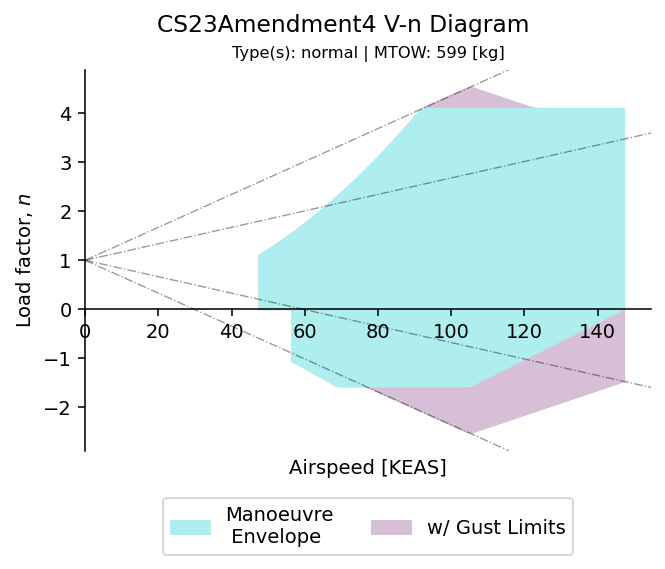

In [10]:
fig, ax = cs23eval.plot_Vn()

## Anatomy of the V-n diagram

A V-n diagram, such as this one, is actually two diagrams on top of one another.
The effects of manoeuvre loads - or, the manoeuvre envelope (pale turquoise) are superimposed on the effects of gust loads - or, the gust envelope (thistle colouration).

### Defining features of the Manoeuvre envelope

Let us begin in the origin of the diagram with the positive...

#### ... stall line.

This is the maximum normal load factor that the aircraft is capable of achieving through the deflection of its control surfaces - for any given airspeed, increasing the $C_L$ and therefore the load factor $n$ is only possible up to this line, where $C_{L,\text{max}}$
 is reached and stall will follow.

The load factor is simply the ratio of the normal accelerating resultant force acting on the aircraft and its unaccelerated weight:

$$
n(V)
= \frac{L}{W}
= \frac{\tfrac{1}{2} \rho_0 V^2 S C_L}{W}
$$

which peaks when the lift coefficient 'maxes out', so $n_{\text{max}}$ is the maximum achievable lift over the weight:

$$
n_{\text{max}}
= \frac{L_{\text{max}}(V)}{W}
= \frac{\tfrac{1}{2} \rho_0 V^2 S C_L}{W}
= \frac{\tfrac{1}{2} \rho_0 V^2 C_L}{W / S}
$$
 
 
 
 
.

Now, with increasing equivalent airspeed, this maximum achievable load factor increases, but at a value denoted...

 #### ... $V_A$ or manoeuvre speed,

...it reaches the limit load factor permitted by the certification requirements document (e.g., CS-23, paragraph 23.337) - 3.8 in the case of this example. In other words, once you have exceeded the manoeuvre speed, a full deflection of the control surfaces (if they have sufficient authority) may cause the airframe to exceed the limit load factor.

A similar logic applies to the 'negative $g$' stall line (0-G on the diagram).

The stall curves are typically 'closed off' at the 1g (or -1g) point, as in the area to the left of these points the aircraft is not capable of generating sufficient lift to support its weight (this is literally what a sub-unity load factor means), even in steady, level flight. Somewhat colloquially the corresponding speeds are often referred to as 'the stall speeds' (normal and inverted), although we must place inverted commas around this because, technically, as this very diagram makes plain, you can stall an aeroplane at any speed if you exceed its maximum lift coefficient.

Other significant speeds that determine the shape of both envelopes are...

#### ...the design cruise speed $V_C$ and the design dive speed $V_D$.

While $V_C$ is, of course, related to the operationally most favourable speed of the aircraft (for example, the speed that maximises its range), this 'certification value' of the cruise speed must be chosen quite carefully because airworthiness requirements, such as CS 23.335 establish a series of quite complicated constraints and relationships between $V_C$, $V_D$, wing loading and so on.

When choosing $V_D$, the designer must also bear in mind the various aeroealsticity-related issues of high speed flight. See, for example, the stipulations in CS 23.629, such as that 'any rational analysis used to predict freedom from flutter, control reversal and divergence must cover all speeds up to 1.2 $V_D$'

### Gust loads

Let us now consider the impact of accounting for gust loads.

These are caused by rising or sinking columns of air which the aircraft might penetrate, with the result being a temporary increase or decrease, respectively, of the angle of attack and thus the load factor. The gust-related load factor increases linearly with airspeed, which is why we see gust lines on the diagram (emanating from the (0,1) point).

CS 23.333 requires that we account for positive (up) and negative (down) gusts of 50 fps (or 15.24m/s) at $V_C$ at altitudes between sea level and 6,096m (20,000ft). Points C and F on the diagram indicate the load factor values calculated for +/-50fps respectively at this speed and this gives us the first pair of gust lines (CS 23.341 tells us how to calculate the gust load factor as a function of airspeed).

Similarly, positive and negative gusts of 25fps at $V_D$ must be considered at altitudes below 20,000ft, which yields the next pair of gust lines.

Finally, all four lines are trimmed at $V_C$ and $V_D$ as appropriate and the end points of the positive pair and the negative pair are connected with straight lines, as per the last paragraph of 23.333.

With all the key constraints and landmark points in place, the complete flight envelope can be drawn up (shown as the shaded area here). This is done by taking the more conservative of the manoeuvre and gust envelopes in each point of the V-n space.

ADRpy does all this construction work automatically, but if you're drawing your own diagram or writing your own code you may wish to look out for a few gotchas.

An example is the tricky corner around point A, where, if the 50fps gust line does not intersect the stall curve, you have to extend the latter until it does. The abscissa of the intersection point is...

... $V_B$, a.k.a, the maximum gust intensity speed.

This speed is noteworthy, because above it the strongest expected gust - 50fps in this case, but may have to be assumed as high as 66fps for commuter category aircraft - could cause the aircraft to stall. A hat tip to Snorri Gudmundsson for pointing out in his GA aircraft design book that this 'corner' does not appear in the example diagram shown in Part 23, but may well be a feature of aircraft with low wing loadings.

### Notes

1. Not all structural limitations of an airframe are captured in a V-n diagram. Asymmetrical air loads and landing loads are notable exceptions.

2. Some structural limitations seen on aircraft placards are not due to V-n diagram violations. For example flap deployment at high altitudes may be prohibited simply because the manufacturer did not apply for this condition to be permitted (they may not have seen a sufficiently compelling need to certify it).

3. The ADRpy implementation of the V-n diagram is currently limited to Part 23 aircraft (CS-23/14 CFR 23). Part 25 and other algorithms may be included in future releases.

4. The example discussed here applies to a single altitude - weight - configuration combination (sea level - MTOW - clean). V-n diagrams are typically drawn up for a range of such combinations and different combinations may be critical for different components of the aircraft. For example, the minimum flying weight may be critical for structural components sized for inertial loads, such as engine pylons or various parts of the internal secondary structure (supports, equipment mounts, etc.).

5. We are largely concerned with limit loads here, but structural design also requires fatigue calculations. For these you may need to consider loading spectra too - see, for example FAA Advisory Circular AC 23-13A 'Fatigue, Fail-Safe, And Damage Tolerance Evaluation Of Metallic Structures For Normal, Utility, Acrobatic, and Commuter Category Airplanes', which sets out acceptable means of showing compliance on this aspect with 14 CFR Part 23.

## Another worked example: Twin turboprop commuter

Let us now consider another example, based on a Beechcraft 1900D-like commuter turboprop (most of the inputs are simply guesses and not based on any proprietary data).

In [11]:
designbrief = {"vstallclean_kcas": 101}

designdef = {
    "aspectratio": 10.48,
    "weight_n": uc.lbf_N(17120)
}

designperf = {
    "CLmax": 1.6, "CLmin": -1, "CLalpha": 6.28
}

designatm = at.Atmosphere() # set the design atmosphere to a zero-offset ISA

designpropulsion = "Turboprop" 

Max operating speed: 248KIAS up to 13,200ft, M0.48 above (at 20,000ft M0.48 = 293KTAS = 214KEAS):
$V_D = 248$, $V_C \sim 204$

In [12]:
Beech1900Dconcept = ca.AircraftConcept(
    brief=designbrief,
    design=designdef,
    performance=designperf,
    atmosphere=designatm,
    propulsion=designpropulsion
)

C:\Users\yr3g17\OneDrive - University of Southampton\Documents\Python\ADRpy\src\ADRpy\constraintanalysis.py:766: RuntimeWarning: Wing geometry is underdefined. Filling in the gaps...
  self.design = ACdefinition(design)


In [13]:
Beech1900Dcs23spec = aw.CS23Amendment4(Beech1900Dconcept, "commuter", uc.ft2_m2(310))

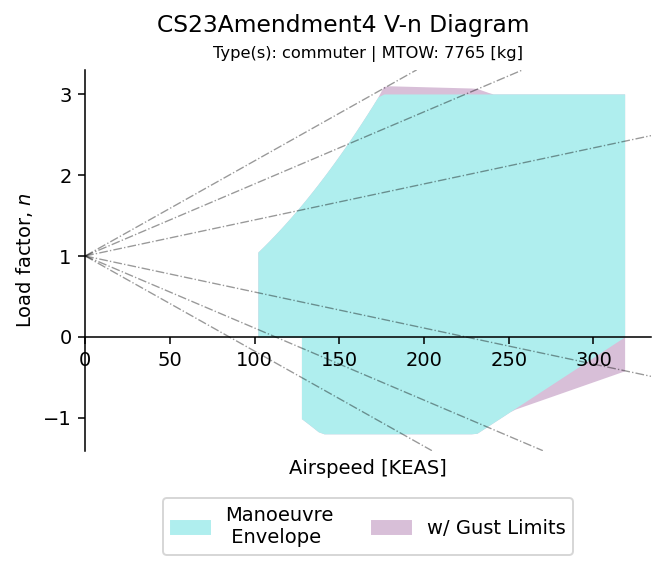

In [14]:
fig, ax = Beech1900Dcs23spec.plot_Vn(weightfraction=1)

## Another worked example: Jet Airliner

This worked example is loosely based on the Airbus A320.

C:\Users\yr3g17\OneDrive - University of Southampton\Documents\Python\ADRpy\src\ADRpy\constraintanalysis.py:766: RuntimeWarning: Wing geometry is underdefined. Filling in the gaps...
  self.design = ACdefinition(design)


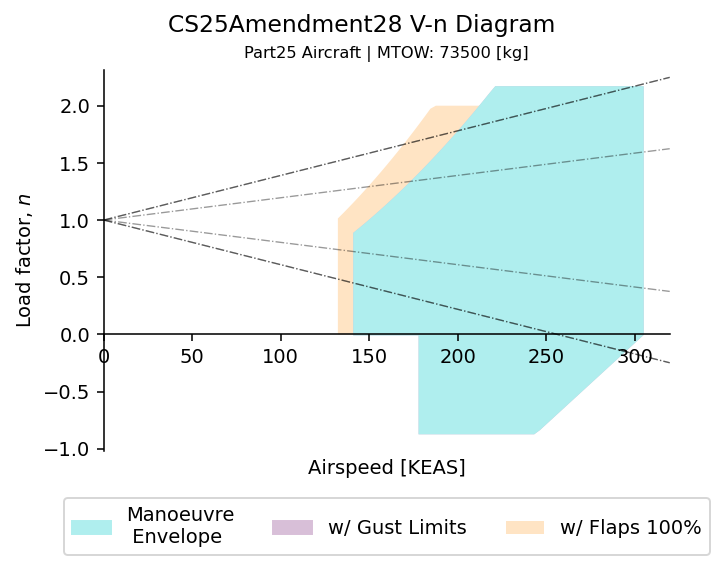

In [15]:
designbrief = {"vstallclean_kcas": 140, "cruisespeed_ktas": uc.mps_kts(230), "cruisealt_m":11e3, "servceil_m": 12.5e3}

b_ft, S_ft2 = 123, 1320

designdef = {
    "aspectratio": b_ft ** 2 / S_ft2,
    "weight_n": uc.kg_N(73500)
}

designperf = {
    "CLmax": 1.6, "CLmin": -1, "CLalpha": 5.3,
    "CLmaxHL": 2.10, "CLminHL": -0.75
}

designatm = at.Atmosphere() # set the design atmosphere to a zero-offset ISA

designpropulsion = "TurbofanHiBPR"

A320concept = ca.AircraftConcept(
    brief=designbrief,
    design=designdef,
    performance=designperf,
    atmosphere=designatm,
    propulsion=designpropulsion
)

A320cs25spec = aw.CS25Amendment28(A320concept, uc.ft2_m2(S_ft2))

fig, ax = A320cs25spec.plot_Vn(weightfraction=1)

# References

[1]  Gudmundsson, S., "General Aviation Aircraft Design: Applied Methods and Procedures", Butterworth-Heinemann, 2013. 